In [1]:
import pandas as pd #type:ignore
import numpy as np #type:ignore
import matplotlib.pyplot as plt #type:ignore
import seaborn as sns #type:ignore
from datetime import timedelta
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression #type:ignore
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier #type:ignore
from sklearn.model_selection import train_test_split, GridSearchCV #type:ignore
from sklearn.preprocessing import StandardScaler #type:ignore
from sklearn.metrics import classification_report, confusion_matrix #type:ignore
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer #type:ignore

from imblearn.over_sampling import RandomOverSampler, SMOTE #type:ignore

In [2]:
location = "data/weatherAUS_cluster.csv"

df= pd.read_csv(location, index_col=0)

df['Date'] = pd.to_datetime(df['Date'])

In [3]:
def print_report(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    display(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predictions']))

In [4]:
def generate_serie(df: pd.DataFrame, index, sequence_length):
    start = index - sequence_length + 1
    end = index + 1
    X = df.iloc[start:end].drop(columns=['Location', 'Date', 'Cluster', 'RainTomorrow'])
    y = df.iloc[index]['RainTomorrow'].astype('int')

    X = np.array(X)
    
    return X, y

In [5]:
def generate_serie_complete(df: pd.DataFrame, sequence_length):
    locations = df['Location'].unique()
    X = []
    Y = []
    for i, location in enumerate(locations):
        df_temp = df[df['Location'] == location]
        n_lines = df_temp.shape[0]
        for index in range(sequence_length-1, n_lines):
            print(f"{i+1}/{len(locations)}: {location} - {(index+1)/n_lines:.1%}", " "*20, end='\r')
            x, y = generate_serie(df_temp, index, sequence_length)
            X.append(x)
            Y.append(y)
            pass
        pass

    X = np.array(X)
    Y = np.array(Y).reshape(-1)
    
    return X, Y

In [6]:
def get_oversampling_serie(X, Y):

    smote = SMOTE(random_state=2406, n_jobs=-1)
    indexes_X = np.arange(len(Y))  # Crear un índice para rastrear secuencias
    indixes_resampled, Y_over = smote.fit_resample(indexes_X.reshape(-1, 1), Y)

    X_over = X[indixes_resampled.ravel()]
    
    return X_over, Y_over

In [7]:
sequence_length = 5

In [8]:
X, y = generate_serie_complete(df, sequence_length)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2406)

In [10]:
X_train, y_train = get_oversampling_serie(X_train, y_train)

In [11]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [12]:
clf_rf = RandomForestClassifier(random_state=2406, n_jobs=-1)
clf_rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=2406)

In [13]:
y_pred = clf_rf.predict(X_test)
print_report(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     21566
           1       0.66      0.71      0.68      6070

    accuracy                           0.86     27636
   macro avg       0.79      0.80      0.79     27636
weighted avg       0.86      0.86      0.86     27636



Predictions,0,1
Real,,
0,19350,2216
1,1790,4280


In [22]:
params_grid = {'n_estimators': [10,50,100,250,500],
               'criterion': ['gini', 'entropy', 'log_loss'],
               'max_features': ['sqrt', 'log']}

clf = RandomForestClassifier(random_state=2406, n_jobs=-1)
n_estimators_list = [10,50,100,250,500]
criterion_list = ['gini', 'entropy', 'log_loss']
max_features_list = ['sqrt', 'log2']

f1_scores = {}
accuracies_scores = {}
precision_scores = {}
recall_scores = {}

best_n_estimators = None
best_criterion = None
best_max_features = None
best_f1_score = 0

i = 1
total = len(n_estimators_list) * len(criterion_list) * len(max_features_list) 
for n_estimators in n_estimators_list:
    for criterion in criterion_list:
        for max_features in max_features_list:
            name = f"{i}/{total} - ({str(n_estimators)}, {criterion}, {max_features})" 
            print(name)
            clf = RandomForestClassifier(random_state=2406,
                                         n_jobs=-1,
                                         n_estimators=n_estimators,
                                         criterion=criterion,
                                         max_features=max_features)
            clf.fit(X_train,y_train)
            y_pred = clf.predict(X_test)
            f1_result = f1_score(y_test, y_pred)
            acc_result = clf.score(X_test, y_test)
            prec_result = precision_score(y_test, y_pred)
            recall_result = recall_score(y_test, y_pred)

            if f1_result > best_f1_score:
                best_f1_score = f1_result
                best_n_estimators = n_estimators
                best_criterion = criterion
                best_max_features = max_features

            print(f"Accuracy: {acc_result:.3f}")
            print(f"F1_Score: {f1_result:.3f}")
            i+=1
            pass
        pass
    pass

print(f"Best: ({str(best_n_estimators)}, {best_criterion}, {best_max_features})")




1/30 - (10, gini, sqrt)
Accuracy: 0.798
F1_Score: 0.588
2/30 - (10, gini, log2)
Accuracy: 0.794
F1_Score: 0.584
3/30 - (10, entropy, sqrt)
Accuracy: 0.803
F1_Score: 0.598
4/30 - (10, entropy, log2)
Accuracy: 0.797
F1_Score: 0.586
5/30 - (10, log_loss, sqrt)
Accuracy: 0.803
F1_Score: 0.598
6/30 - (10, log_loss, log2)
Accuracy: 0.798
F1_Score: 0.587
7/30 - (50, gini, sqrt)
Accuracy: 0.850
F1_Score: 0.671
8/30 - (50, gini, log2)
Accuracy: 0.844
F1_Score: 0.662
9/30 - (50, entropy, sqrt)
Accuracy: 0.849
F1_Score: 0.670
10/30 - (50, entropy, log2)
Accuracy: 0.847
F1_Score: 0.667
11/30 - (50, log_loss, sqrt)
Accuracy: 0.849
F1_Score: 0.670
12/30 - (50, log_loss, log2)
Accuracy: 0.847
F1_Score: 0.667
13/30 - (100, gini, sqrt)
Accuracy: 0.855
F1_Score: 0.681
14/30 - (100, gini, log2)
Accuracy: 0.852
F1_Score: 0.675
15/30 - (100, entropy, sqrt)
Accuracy: 0.853
F1_Score: 0.677
16/30 - (100, entropy, log2)
Accuracy: 0.853
F1_Score: 0.676
17/30 - (100, log_loss, sqrt)
Accuracy: 0.853
F1_Score: 0.6

In [ ]:
params_grid = {'n_estimators': [10,50,100,250,500],
               'criterion': ['gini', 'entropy', 'log_loss'],
               'max_features': ['sqrt', 'log']}

clf = RandomForestClassifier(random_state=2406, n_jobs=-1)

grid2 = GridSearchCV(estimator=clf,
                     param_grid=params_grid,
                     scoring=make_scorer(f1_score(pos_label=1))
                     cv=5,
                     n_jobs=-1,
                     verbose=1
                     )

grid2.fit(X_train,y_train)

In [31]:
count_rt = df['RainTomorrow'].value_counts(normalize=True)
count_rt

RainTomorrow
0.0    0.778777
1.0    0.221223
Name: proportion, dtype: float64

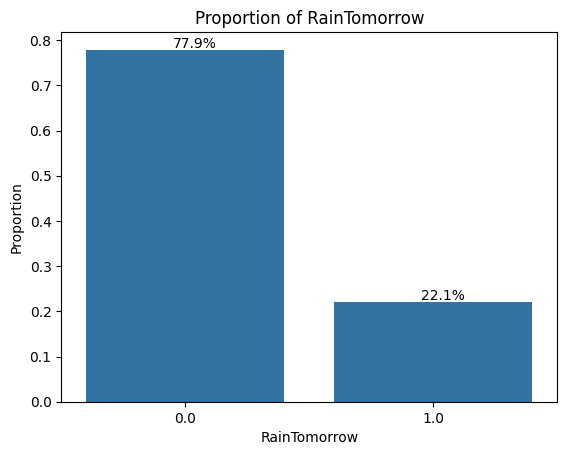

In [50]:
sns.barplot(count_rt);
plt.title("Proportion of RainTomorrow");
plt.ylabel("Proportion");
plt.annotate(f"{count_rt.iloc[0]:.1%}", (-0.05,count_rt.iloc[0]+0.005));
plt.annotate(f"{count_rt.iloc[1]:.1%}", (1-0.05,count_rt.iloc[1]+0.005));